In [ ]:
# Standard libraries
import os
from typing import Dict, Any, List, Optional, Tuple

# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import stats

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

# Display settings
from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)
sns.set_theme(style="dark", palette="pastel", font_scale=1.1)

%matplotlib inline

## 1. Загрузка и предобработка данных

In [2]:
def load_data(filepath: str, expected_columns: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Load and validate dataset from CSV file.

    Args:
        filepath: Path to the CSV file
        expected_columns: List of expected column names for validation

    Returns:
        pd.DataFrame: Loaded and validated dataframe

    Raises:
        FileNotFoundError: If file doesn't exist
        ValueError: If data validation fails
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    try:
        df = pd.read_csv(filepath, encoding='utf-8')

        if expected_columns and not all(col in df.columns for col in expected_columns):
            missing_cols = set(expected_columns) - set(df.columns)
            raise ValueError(f"Missing required columns: {missing_cols}")

        if df.empty:
            raise ValueError("Dataset is empty")

        print(f"✅ Data loaded successfully:")
        print(f"   - Rows: {len(df):,}")
        print(f"   - Columns: {len(df.columns):,}")
        print(f"   - Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

        return df

    except Exception as e:
        raise RuntimeError(f"❌ Error loading data: {str(e)}")

In [3]:
# Загрузка данных
FILEPATH = 'results.csv'
df = load_data(FILEPATH)

# Первичный осмотр
display(df.head(3))
print("\nМетаданные:")
display(df.info())

✅ Data loaded successfully:
   - Rows: 2,373
   - Columns: 9
   - Memory usage: 0.16 MB


,id,rating,comment,Нравится скорость отработки заявок,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Понравилось выполнение заявки,Запрос решен,Некорректный комментарий
0,2945792,5,спасибо,0,0,0,1,1,0
1,3234340,5,спасибо!,0,0,0,1,1,0
2,3380332,5,Отлично,0,1,0,1,1,0



Метаданные:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    2373 non-null   int64 
 1   rating                                2373 non-null   int64 
 2   comment                               2373 non-null   object
 3   Нравится скорость отработки заявок    2373 non-null   int64 
 4   Нравится качество выполнения заявки   2373 non-null   int64 
 5   Нравится качество работы сотрудников  2373 non-null   int64 
 6   Понравилось выполнение заявки         2373 non-null   int64 
 7   Запрос решен                          2373 non-null   int64 
 8   Некорректный комментарий              2373 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 167.0+ KB


None

## 2. Статистический анализ

In [4]:
def calculate_descriptive_stats(df: pd.DataFrame, numeric_cols: List[str]) -> Dict[str, Any]:
    """
    Calculate comprehensive descriptive statistics for numeric columns.
    """
    stats_dict = {}

    for col in numeric_cols:
        col_stats = {
            'basic_stats': df[col].describe(),
            'skewness': df[col].skew(),
            'kurtosis': df[col].kurtosis(),
            'iqr': df[col].quantile(0.75) - df[col].quantile(0.25),
            'mode': df[col].mode().iloc[0],
            'missing_pct': (df[col].isna().sum() / len(df)) * 100,
            'unique_values': df[col].nunique(),
        }

        # Add normality test
        _, p_value = stats.normaltest(df[col].dropna())
        col_stats['is_normal'] = p_value > 0.05

        stats_dict[col] = col_stats

    return stats_dict

def analyze_categorical_features(df: pd.DataFrame, cat_cols: List[str]) -> Dict[str, Any]:
    """
    Analyze categorical features including binary ones.
    """
    cat_stats = {}

    for col in cat_cols:
        value_counts = df[col].value_counts()
        proportions = df[col].value_counts(normalize=True) * 100

        cat_stats[col] = {
            'counts': value_counts,
            'proportions': proportions,
            'unique_values': df[col].nunique(),
            'missing_pct': (df[col].isna().sum() / len(df)) * 100,
            'mode': df[col].mode().iloc[0],
            'entropy': stats.entropy(proportions)
        }

    return cat_stats

def perform_outlier_analysis(df: pd.DataFrame, numeric_cols: List[str],
                           threshold: float = 1.5) -> Dict[str, Any]:
    """
    Perform comprehensive outlier analysis using IQR method.
    """
    outlier_stats = {}

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

        outlier_stats[col] = {
            'outlier_count': len(outliers),
            'outlier_percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    return outlier_stats

## 4. Визуализация результатов

In [5]:
def create_interactive_distribution_plot(df: pd.DataFrame, numeric_cols: List[str]) -> None:
    """
    Create interactive distribution plots using plotly.
    """
    for col in numeric_cols:
        fig = make_subplots(rows=2, cols=1,
                           subplot_titles=(f'Distribution of {col}',
                                         f'Box Plot of {col}'))

        # Histogram
        fig.add_trace(
            px.histogram(df, x=col).data[0],
            row=1, col=1
        )

        # Box plot
        fig.add_trace(
            px.box(df, y=col).data[0],
            row=2, col=1
        )

        fig.update_layout(height=800, showlegend=False)
        fig.show()

def plot_correlation_matrix(df: pd.DataFrame, method: str = 'pearson') -> None:
    """
    Create an enhanced correlation matrix plot for numeric columns only.

    Args:
        df: Input dataframe
        method: Correlation method ('pearson', 'spearman', or 'kendall')
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['int64', 'float64'])

    if numeric_df.empty:
        print("⚠️ No numeric columns found for correlation analysis")
        return

    try:
        corr_matrix = numeric_df.corr(method=method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm',
                    linewidths=0.5, fmt='.2f', vmin=-1, vmax=1)
        plt.title(f'{method.capitalize()} Correlation Matrix', pad=20)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error creating correlation matrix: {str(e)}")

In [6]:
def generate_summary_report(df: pd.DataFrame, stats_dict: Dict) -> None:
    """
    Generate a comprehensive summary report in Markdown format.
    """
    report = [
        "# Dataset Analysis Report\n",
        f"## Overview\n"
        f"- Total observations: {len(df):,}\n"
        f"- Total features: {len(df.columns):,}\n"
        f"- Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB\n",
        "## Data Quality\n"
        f"- Missing values: {df.isna().sum().sum():,}\n"
        f"- Duplicate rows: {df.duplicated().sum():,}\n",
    ]

    display(Markdown('\n'.join(report)))

## 5. Выполнение анализа

✅ Data loaded successfully:
   - Rows: 2,373
   - Columns: 9
   - Memory usage: 0.16 MB

Column types:
Numeric columns: ['id', 'rating', 'Нравится скорость отработки заявок', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Понравилось выполнение заявки', 'Запрос решен', 'Некорректный комментарий']
Categorical columns: ['comment']


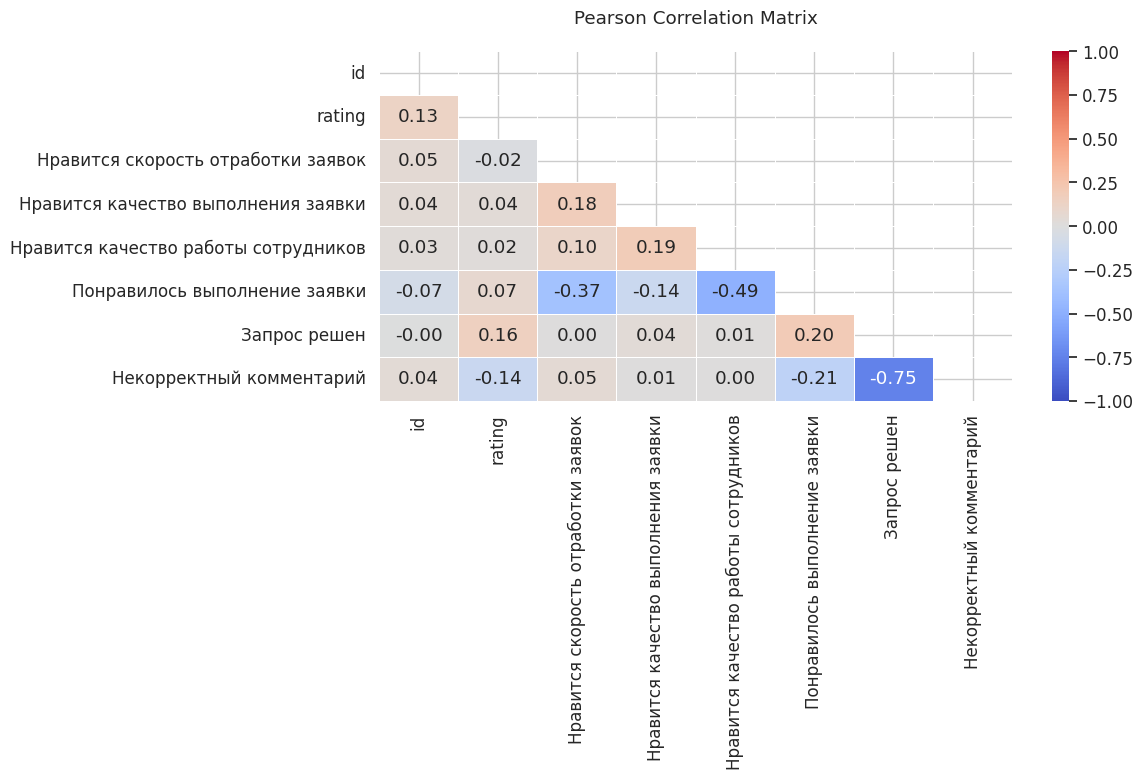

# Dataset Analysis Report

## Overview
- Total observations: 2,373
- Total features: 9
- Memory usage: 0.16 MB

## Data Quality
- Missing values: 0
- Duplicate rows: 63


In [7]:
# Main analysis execution
if __name__ == "__main__":
    # Load and validate data
    df = load_data(FILEPATH)

    # Identify column types
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    print("\nColumn types:")
    print(f"Numeric columns: {list(numeric_cols)}")
    print(f"Categorical columns: {list(categorical_cols)}")

    # Calculate statistics
    desc_stats = calculate_descriptive_stats(df, numeric_cols)
    cat_stats = analyze_categorical_features(df, categorical_cols)
    outlier_stats = perform_outlier_analysis(df, numeric_cols)

    # Generate visualizations
    if len(numeric_cols) > 0:
        create_interactive_distribution_plot(df, numeric_cols)
        plot_correlation_matrix(df)
    else:
        print("⚠️ No numeric columns found for visualization")

    # Generate summary report
    generate_summary_report(df, {
        'descriptive': desc_stats,
        'categorical': cat_stats,
        'outliers': outlier_stats
    })